In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
print(os.listdir("../input"))
sns.set_style('dark')
sns.set_context('talk')
# Any results you write to the current directory are saved as output.

['creditcard.csv']


## Reading Data:

In [2]:
df = pd.read_csv('../input/creditcard.csv', encoding = 'latin1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()


False

## Distribution Analysis:

Distribution of fraudulent points: 0.17%


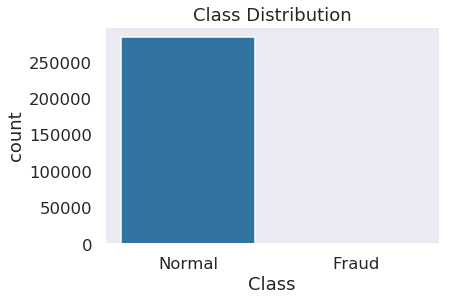

In [6]:
print(("Distribution of fraudulent points: {:.2f}%".format(len(df[df['Class']==1])/len(df)*100)))
sns.countplot(df['Class'])
plt.title('Class Distribution')
plt.xticks(range(2),['Normal','Fraud'])
plt.show()


As the Data is highly imbalanced with one class being only 0.17%  We are taking this as an anomaly detection problem. 

## Class wise Analysis:

In [7]:
normal = df[df['Class']==0]
fraud = df[df['Class']==1]
print("Normal datapoints: ", normal.shape[0])
print("Fraud datapoints: ", fraud.shape[0])

Normal datapoints:  284315
Fraud datapoints:  492


In [8]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [9]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

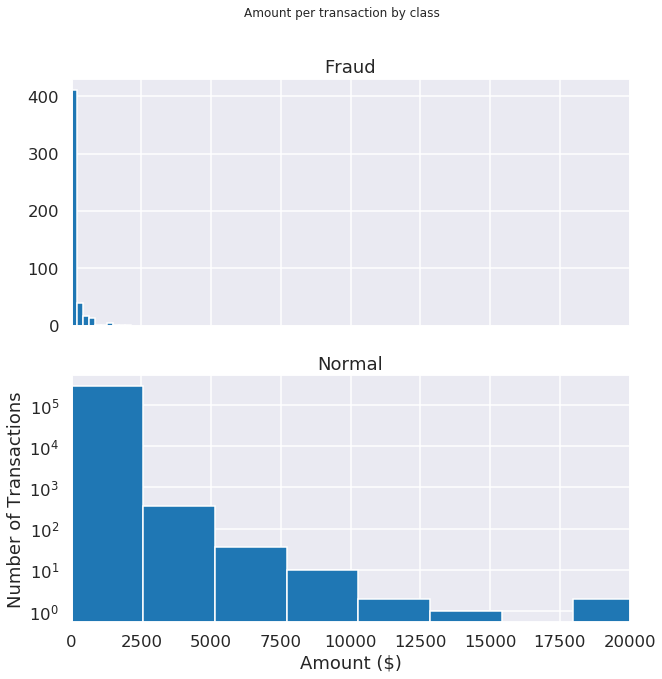

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,10) )
f.suptitle('Amount per transaction by class')

bins = 10

ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

ax1.grid()
ax2.grid()
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

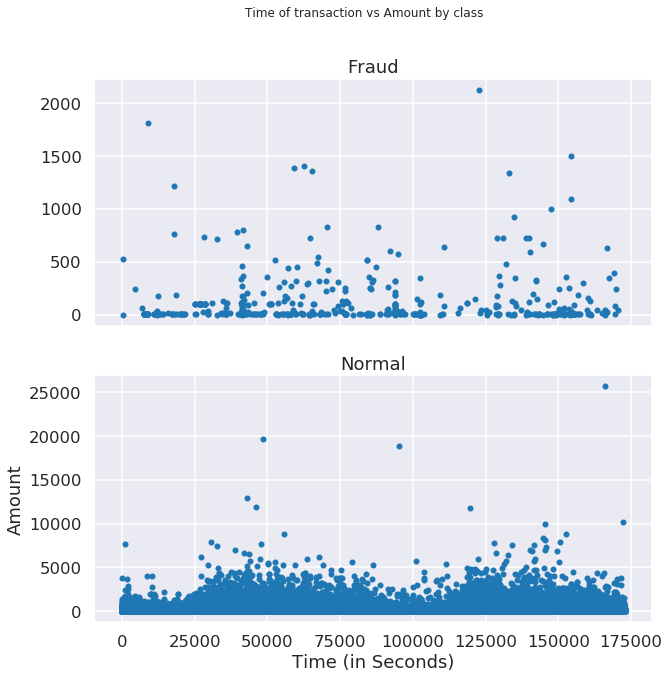

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraud.Time, fraud.Amount, marker='.')
ax1.set_title('Fraud')
ax1.grid()
ax2.scatter(normal.Time, normal.Amount, marker='.')
ax2.set_title('Normal')
ax2.grid()
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Data Modeling

In [12]:
data = df.drop(['Time'], axis =1)

In [13]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train
X_test = X_test
print(X_train.shape)

print(X_test.shape)
print(y_test.shape)

(227451, 29)
(56962, 29)
(56962,)


In [14]:
scaler = StandardScaler().fit(X_train.Amount.values.reshape(-1,1))
X_train['Amount'] = scaler.transform(X_train.Amount.values.reshape(-1,1))
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

In [15]:
X_train.shape

(227451, 29)

Here we are going to use Autoencoder and train it on X_train having only normal points, so when it learns the internal pattern of normal transactions we can use it to distinguish between normal and fraud data points. 

## Model Training:

In [16]:
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [17]:
input_dim = X_train.shape[1]
encoding_dim = 14


In [18]:
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [19]:
X_train.shape

(227451, 29)

In [20]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    )

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.3,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 159215 samples, validate on 68236 samples
Epoch 1/100
159215/159215 [==============================] - 20s 123us/step - loss: 0.8153 - val_loss: 0.8084
Epoch 2/100
159215/159215 [==============================] - 19s 119us/step - loss: 0.7428 - val_loss: 0.7899
Epoch 3/100
159215/159215 [==============================] - 20s 123us/step - loss: 0.7335 - val_loss: 0.7850
Epoch 4/100
159215/159215 [==============================] - 19s 119us/step - loss: 0.7280 - val_loss: 0.7761
Epoch 5/100
159215/159215 [==============================] - 19s 122us/step - loss: 0.7228 - val_loss: 0.7715
Epoch 6/100
159215/159215 [==============================] - 19s 119us/step - loss: 0.7190 - val_loss: 0.7685
Epoch 7/100
159215/159215 [==============================] - 19s 121us/step - loss: 0.7159 - val_loss: 0.7638
Epoch 8/100
159215/159215 [==============================] - 19s 119us/step - loss: 0.7132 - val_loss: 0.7622
Epoch 9/100
159215/159215 [==============================] - 19s 119u

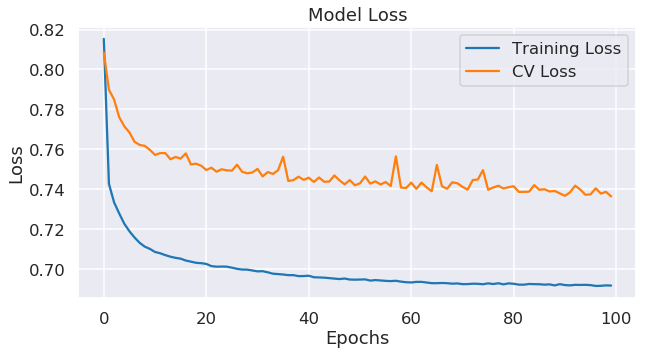

In [21]:
plt.figure(figsize = (10,5))
plt.plot(history['loss'], label = 'Training Loss')
plt.plot(history['val_loss'], label = 'CV Loss')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [22]:
autoencoder = load_model('model.h5')

## Model Evaluation:

In [23]:
predictions = autoencoder.predict(X_test)

In [24]:
predictions.shape

(56962, 29)

mse here is basically the reconstruction error, if the model has learned the normal datapoints well, then this error should be less on normal points, and high on fraud points. 

In [25]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class':y_test})

In [26]:
error_df.groupby(['true_class']).describe()

reconstruction_error                ...                           
                          count       mean     ...            75%         max
true_class                                     ...                           
0                       56864.0   0.676625     ...       0.612446  153.062496
1                          98.0  30.711210     ...      51.290306  258.021641

[2 rows x 8 columns]

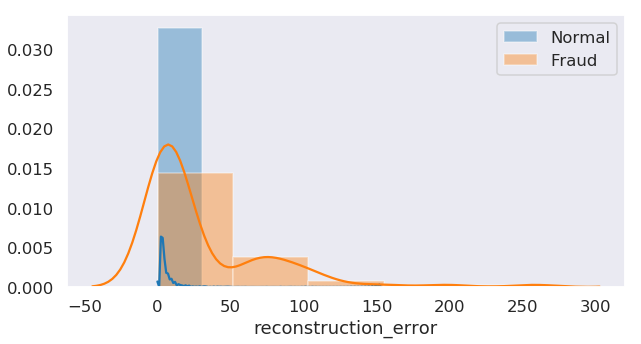

In [27]:
plt.figure(figsize = (10,5))
sns.distplot(error_df[error_df['true_class']==0]['reconstruction_error'], bins = 5, label = 'Normal')
sns.distplot(error_df[error_df['true_class']==1]['reconstruction_error'], bins=5, label = 'Fraud')
plt.legend()
plt.show()


In [28]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, roc_auc_score)

In [29]:
threshold = 1.4

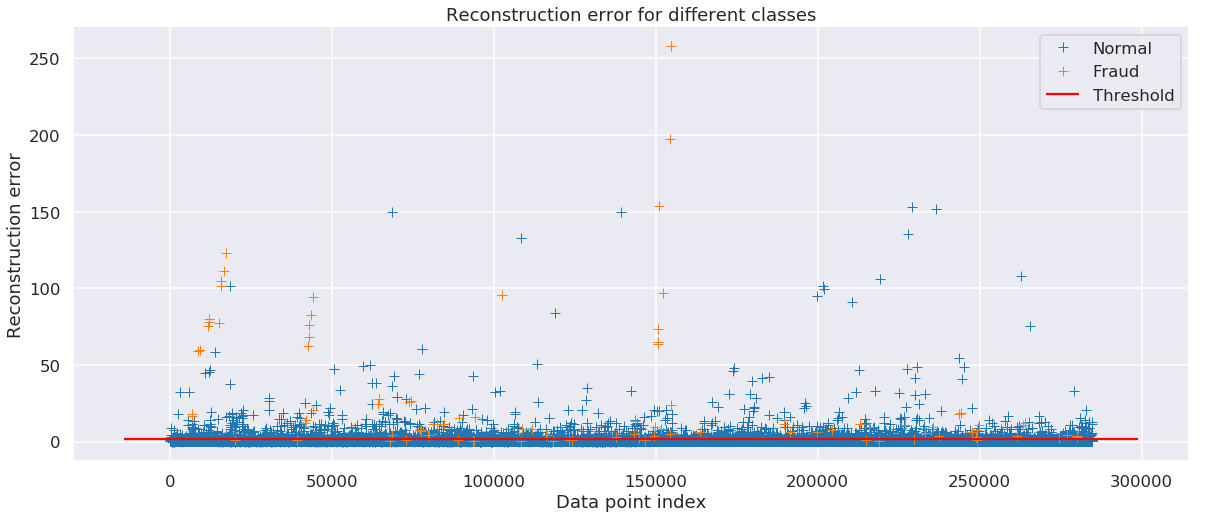

In [30]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize = (20,8))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='+', ms=10, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.grid()
plt.show();


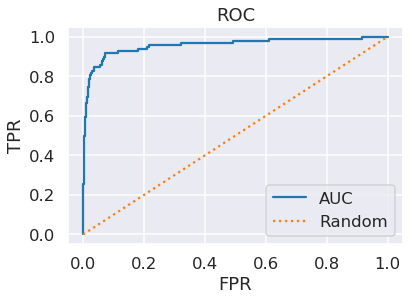

In [31]:
fpr, tpr, thres = roc_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("TPR") 
plt.xlabel("FPR") 
plt.title('ROC') 
plt.show() 

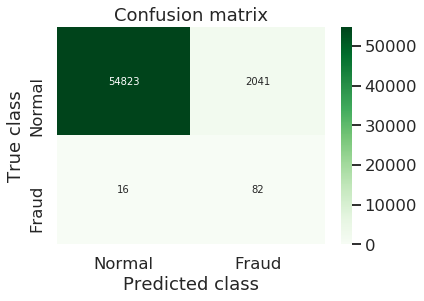

In [32]:
LABELS = ['Normal', 'Fraud']
threshold = 2
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Greens');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [33]:
## Chosen metric is AUC ROC as data is imbalanced
print("Area under ROC : ", roc_auc_score(error_df.true_class,y_pred ))

Area under ROC :  0.9004210188577401


In [34]:
print(classification_report(error_df.true_class,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.84      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.53     56962
weighted avg       1.00      0.96      0.98     56962

